In [ ]:
!pip install insightface
!pip install onnxruntime
!pip install torch torchvision
!pip install opencv-python
!pip install scikit-learn
!pip install matplotlib pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 33.3 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp311-cp311-linux_x86_64.whl size=1060434 sha256=8b99d2a76db7f850f21648d859a9824a886ffe31c7cb3c5ab9437d7179127107
  Stored in directory: /root/.cache/pip/wheels/27/d8/22/f52d858d16cd06e7b2e6aad34a1777dcfaf000be833bbf8146
Successfully built insightface
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.4 MB/s eta 0:00:00

In [ ]:
# Face Recognition Incremental Learning Research Framework
# Research on lightweight face recognition models with transfer learning and joint training

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import cv2
import time
import pickle
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import insightface
from insightface.app import FaceAnalysis
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

class FaceDataset(Dataset):
    """Custom dataset for face recognition training"""

    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

class MobileFaceNetTransfer(nn.Module):
    """Transfer learning wrapper for MobileFaceNet"""

    def __init__(self, num_classes, pretrained_model_path=None):
        super(MobileFaceNetTransfer, self).__init__()

        # Initialize InsightFace model
        self.app = FaceAnalysis(providers=['CPUExecutionProvider'])
        self.app.prepare(ctx_id=0, det_size=(640, 640))

        # Create a simple classifier on top of features
        self.feature_dim = 512  # InsightFace feature dimension
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def extract_features(self, image_path):
        """Extract features using InsightFace"""
        img = cv2.imread(image_path)
        faces = self.app.get(img)

        if len(faces) > 0:
            # Use the largest face
            face = max(faces, key=lambda x: x.bbox[2] * x.bbox[3])
            return face.embedding
        else:
            # Return zero vector if no face detected
            return np.zeros(self.feature_dim)

    def forward(self, x):
        # For training, x will be pre-extracted features
        return self.classifier(x)

    def update_classifier(self, num_classes):
        """Update classifier for new number of classes"""
        old_weight = self.classifier[-1].weight.data
        old_bias = self.classifier[-1].bias.data

        # Create new classifier
        new_classifier = nn.Linear(256, num_classes)

        # Copy old weights
        if num_classes > old_weight.size(0):
            new_classifier.weight.data[:old_weight.size(0)] = old_weight
            new_classifier.bias.data[:old_bias.size(0)] = old_bias

        self.classifier[-1] = new_classifier

class FaceRecognitionResearcher:
    """Main research class for incremental face recognition learning"""

    def __init__(self, dataset_path, batch_size=5):
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Data organization
        self.person_folders = []
        self.trained_persons = []
        self.test_data = {}
        self.training_history = []

        # Performance metrics storage
        self.metrics_history = []
        self.model_sizes = []

        print(f"Using device: {self.device}")

    def organize_dataset(self):
        """Organize dataset into person folders"""
        self.person_folders = [f for f in os.listdir(self.dataset_path)
                              if os.path.isdir(os.path.join(self.dataset_path, f))]
        self.person_folders.sort()
        print(f"Found {len(self.person_folders)} person folders")

        # Prepare test data (1 image per person for testing)
        for person in self.person_folders:
            person_path = os.path.join(self.dataset_path, person)
            images = [f for f in os.listdir(person_path)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            if len(images) > 1:
                # Random selection of test image
                test_img = random.choice(images)
                train_imgs = [img for img in images if img != test_img]

                self.test_data[person] = {
                    'test_image': os.path.join(person_path, test_img),
                    'train_images': [os.path.join(person_path, img) for img in train_imgs]
                }

    def extract_features_batch(self, image_paths):
        """Extract features for a batch of images"""
        features = []
        app = FaceAnalysis(providers=['CPUExecutionProvider'])
        app.prepare(ctx_id=0, det_size=(640, 640))

        for img_path in image_paths:
            img = cv2.imread(img_path)
            faces = app.get(img)

            if len(faces) > 0:
                face = max(faces, key=lambda x: x.bbox[2] * x.bbox[3])
                features.append(face.embedding)
            else:
                features.append(np.zeros(512))

        return np.array(features)

    def prepare_joint_training_data(self, current_batch_persons, previous_persons, augment_factor=2):
        """Prepare joint training data with class balancing"""
        all_features = []
        all_labels = []

        # Current batch data
        current_images = []
        current_labels = []

        for i, person in enumerate(current_batch_persons):
            person_images = self.test_data[person]['train_images']
            current_images.extend(person_images)
            current_labels.extend([len(previous_persons) + i] * len(person_images))

        # Previous batch data (augmented)
        previous_images = []
        previous_labels = []

        for i, person in enumerate(previous_persons):
            person_train_images = self.test_data[person]['train_images']
            # Sample and augment previous person images
            sampled_images = random.choices(person_train_images,
                                          k=min(len(person_train_images),
                                               len(current_images) // len(previous_persons)))

            previous_images.extend(sampled_images * augment_factor)
            previous_labels.extend([i] * len(sampled_images) * augment_factor)

        # Combine all data
        all_images = current_images + previous_images
        all_labels = current_labels + previous_labels

        return all_images, all_labels

    def train_batch(self, batch_persons, is_first_batch=True):
        """Train model on a batch of persons"""
        print(f"\nTraining batch: {batch_persons}")

        start_time = time.time()

        # Prepare training data
        if is_first_batch:
            train_images, train_labels = self.prepare_joint_training_data(
                batch_persons, [], augment_factor=1)
            num_classes = len(batch_persons)
        else:
            train_images, train_labels = self.prepare_joint_training_data(
                batch_persons, self.trained_persons, augment_factor=2)
            num_classes = len(self.trained_persons) + len(batch_persons)

        # Extract features
        print("Extracting features...")
        features = self.extract_features_batch(train_images)

        # Convert to tensors
        features_tensor = torch.FloatTensor(features).to(self.device)
        labels_tensor = torch.LongTensor(train_labels).to(self.device)

        # Initialize or update model
        if is_first_batch:
            self.model = MobileFaceNetTransfer(num_classes)
        else:
            self.model.update_classifier(num_classes)

        self.model.to(self.device)

        # Training setup
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.classifier.parameters(), lr=0.001)

        # Create data loader
        dataset = torch.utils.data.TensorDataset(features_tensor, labels_tensor)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

        # Training loop
        self.model.train()
        for epoch in range(20):  # Reduced epochs for faster training
            total_loss = 0
            for batch_features, batch_labels in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_features)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

        training_time = time.time() - start_time
        self.trained_persons.extend(batch_persons)

        return training_time

    def evaluate_model(self):
        """Evaluate model on all trained persons"""
        if not self.model or not self.trained_persons:
            return {}

        start_time = time.time()

        # Prepare test data
        test_images = []
        true_labels = []

        for i, person in enumerate(self.trained_persons):
            test_images.append(self.test_data[person]['test_image'])
            true_labels.append(i)

        # Extract features for test images
        test_features = self.extract_features_batch(test_images)
        test_features_tensor = torch.FloatTensor(test_features).to(self.device)

        # Predict
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(test_features_tensor)
            predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()

        # Calculate metrics
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
        recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
        f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

        # Calculate FAR and FRR
        cm = confusion_matrix(true_labels, predicted_labels)
        n_classes = len(self.trained_persons)

        if n_classes > 1:
            fp = cm.sum(axis=0) - np.diag(cm)
            fn = cm.sum(axis=1) - np.diag(cm)
            tp = np.diag(cm)
            tn = cm.sum() - (fp + fn + tp)

            far = np.mean(fp / (fp + tn + 1e-8))  # False Acceptance Rate
            frr = np.mean(fn / (fn + tp + 1e-8))  # False Rejection Rate
        else:
            far = 0.0
            frr = 1.0 - accuracy

        execution_time = time.time() - start_time

        # Calculate model size
        model_size = sum(p.numel() * 4 for p in self.model.parameters()) / (1024 * 1024)  # MB

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'far': far,
            'frr': frr,
            'execution_time': execution_time,
            'model_size': model_size,
            'num_persons': len(self.trained_persons)
        }

    def save_model(self, path):
        """Save the trained model"""
        if self.model:
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'trained_persons': self.trained_persons,
                'num_classes': len(self.trained_persons)
            }, path)
            print(f"Model saved to {path}")

    def load_model(self, path, num_classes):
        """Load a saved model"""
        checkpoint = torch.load(path, map_location=self.device)
        self.model = MobileFaceNetTransfer(num_classes)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.trained_persons = checkpoint['trained_persons']
        self.model.to(self.device)
        print(f"Model loaded from {path}")

    def run_incremental_experiment(self):
        """Run the complete incremental learning experiment"""
        print("Starting Incremental Face Recognition Experiment")
        print("=" * 50)

        # Organize dataset
        self.organize_dataset()

        # Create batches of 5 persons each
        batches = [self.person_folders[i:i+self.batch_size]
                  for i in range(0, len(self.person_folders), self.batch_size)]

        results_df = pd.DataFrame()

        for batch_idx, batch_persons in enumerate(batches):
            print(f"\n{'='*20} BATCH {batch_idx + 1} {'='*20}")

            # Train on current batch
            is_first = (batch_idx == 0)
            training_time = self.train_batch(batch_persons, is_first_batch=is_first)

            # Evaluate model
            metrics = self.evaluate_model()
            metrics['batch'] = batch_idx + 1
            metrics['training_time'] = training_time
            metrics['persons_in_batch'] = len(batch_persons)

            # Save model
            model_path = f'model_batch_{batch_idx + 1}.pth'
            self.save_model(model_path)

            # Store results
            self.metrics_history.append(metrics)

            # Print current results
            print(f"\nBatch {batch_idx + 1} Results:")
            print(f"Persons trained: {metrics['num_persons']}")
            print(f"Accuracy: {metrics['accuracy']:.4f}")
            print(f"Precision: {metrics['precision']:.4f}")
            print(f"Recall: {metrics['recall']:.4f}")
            print(f"F1-Score: {metrics['f1_score']:.4f}")
            print(f"FAR: {metrics['far']:.4f}")
            print(f"FRR: {metrics['frr']:.4f}")
            print(f"Training Time: {metrics['training_time']:.2f}s")
            print(f"Execution Time: {metrics['execution_time']:.4f}s")
            print(f"Model Size: {metrics['model_size']:.2f} MB")

        # Create results DataFrame
        results_df = pd.DataFrame(self.metrics_history)

        # Save results
        results_df.to_csv('incremental_learning_results.csv', index=False)

        return results_df

    def plot_results(self, results_df):
        """Plot experiment results"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Accuracy over batches
        axes[0,0].plot(results_df['batch'], results_df['accuracy'], 'b-o')
        axes[0,0].set_title('Accuracy vs Batch')
        axes[0,0].set_xlabel('Batch')
        axes[0,0].set_ylabel('Accuracy')
        axes[0,0].grid(True)

        # F1-Score over batches
        axes[0,1].plot(results_df['batch'], results_df['f1_score'], 'g-o')
        axes[0,1].set_title('F1-Score vs Batch')
        axes[0,1].set_xlabel('Batch')
        axes[0,1].set_ylabel('F1-Score')
        axes[0,1].grid(True)

        # FAR and FRR
        axes[0,2].plot(results_df['batch'], results_df['far'], 'r-o', label='FAR')
        axes[0,2].plot(results_df['batch'], results_df['frr'], 'orange', marker='s', label='FRR')
        axes[0,2].set_title('FAR and FRR vs Batch')
        axes[0,2].set_xlabel('Batch')
        axes[0,2].set_ylabel('Rate')
        axes[0,2].legend()
        axes[0,2].grid(True)

        # Training Time
        axes[1,0].plot(results_df['batch'], results_df['training_time'], 'purple', marker='d')
        axes[1,0].set_title('Training Time vs Batch')
        axes[1,0].set_xlabel('Batch')
        axes[1,0].set_ylabel('Time (seconds)')
        axes[1,0].grid(True)

        # Model Size
        axes[1,1].plot(results_df['batch'], results_df['model_size'], 'brown', marker='^')
        axes[1,1].set_title('Model Size vs Batch')
        axes[1,1].set_xlabel('Batch')
        axes[1,1].set_ylabel('Size (MB)')
        axes[1,1].grid(True)

        # Number of Persons vs Performance
        axes[1,2].plot(results_df['num_persons'], results_df['accuracy'], 'navy', marker='h')
        axes[1,2].set_title('Accuracy vs Number of Persons')
        axes[1,2].set_xlabel('Number of Persons')
        axes[1,2].set_ylabel('Accuracy')
        axes[1,2].grid(True)

        plt.tight_layout()
        plt.savefig('incremental_learning_results.png', dpi=300, bbox_inches='tight')
        plt.show()


Using device: cpu
Starting Incremental Face Recognition Experiment
Found 24 person folders

==================== BATCH 1 ====================

Training batch: ['Alejandro_Toledo', 'Alvaro_Uribe', 'Andre_Agassi', 'Ariel_Sharon', 'Arnold_Schwarzenegger']
Extracting features...
download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:10<00:00, 26025.09KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Applied prov

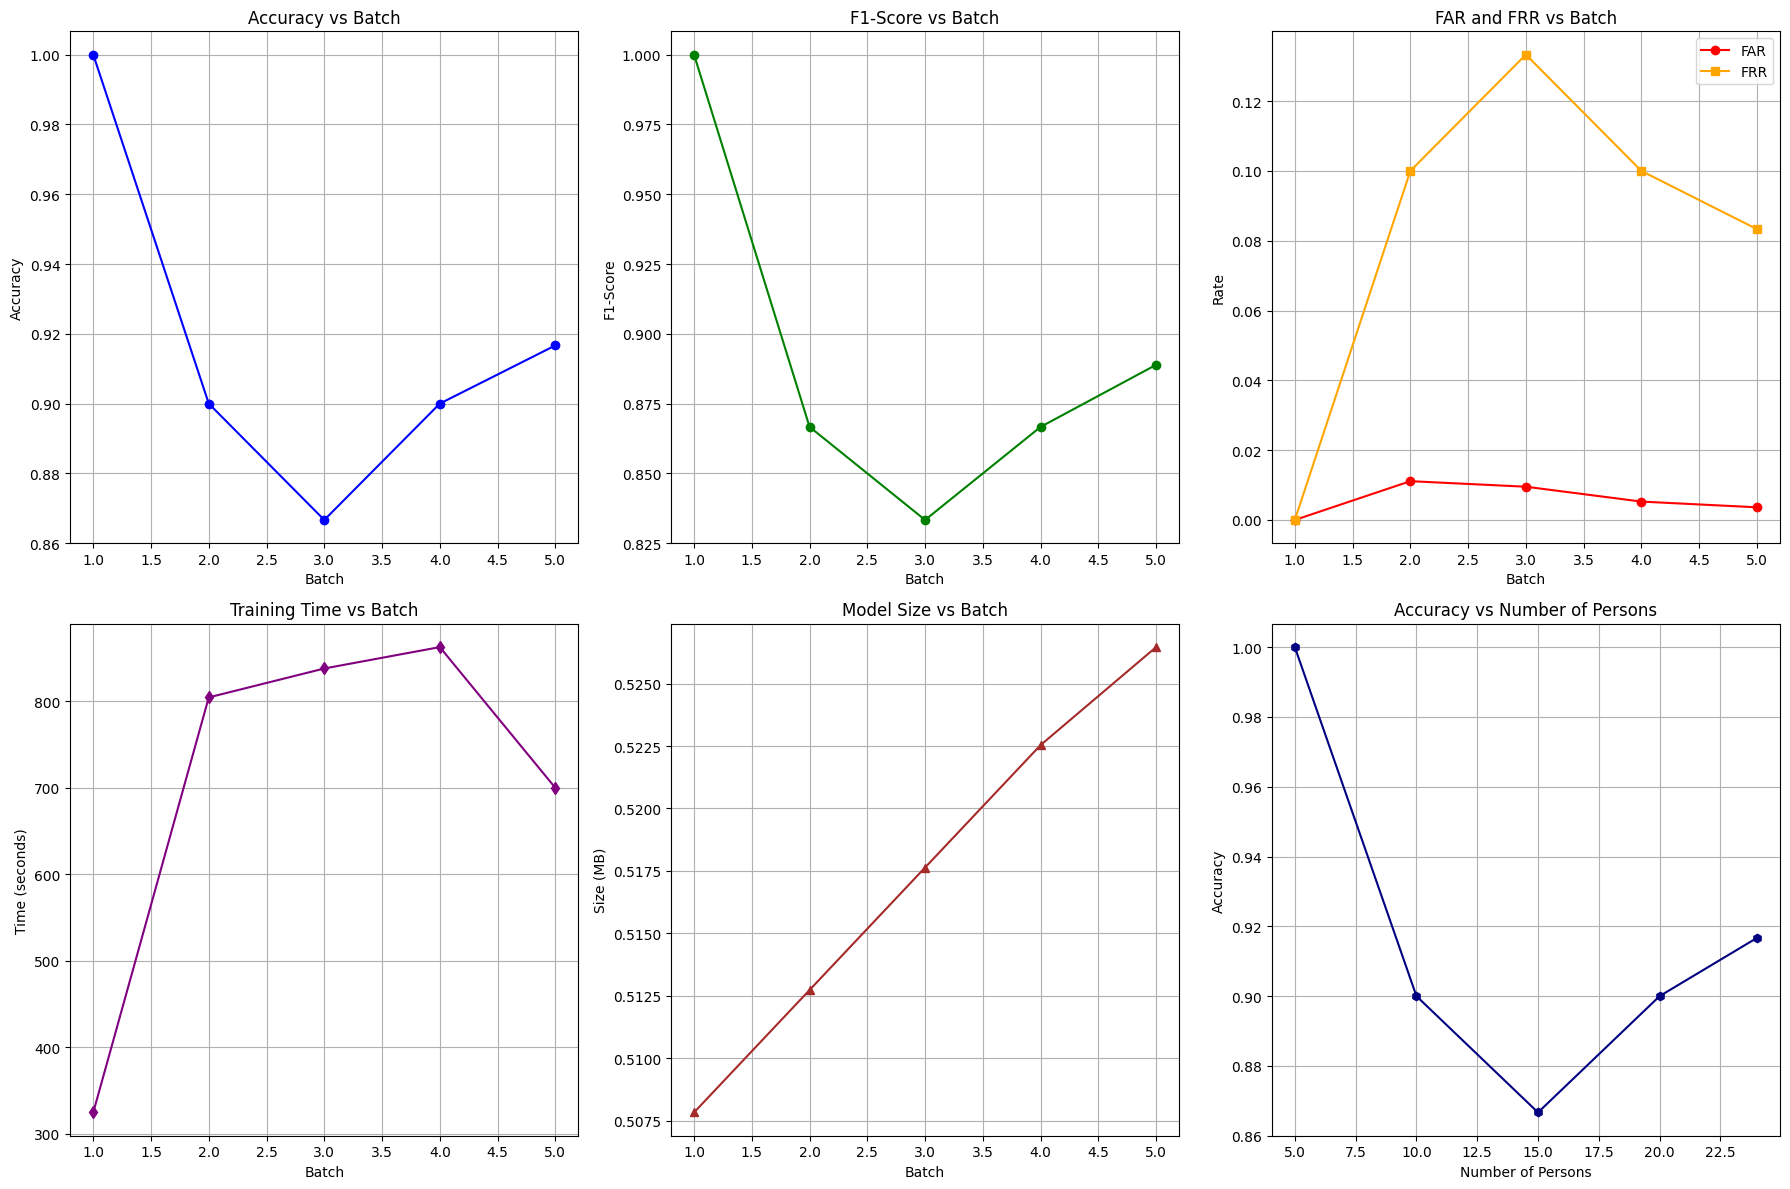


EXPERIMENT SUMMARY
Total persons trained: 24
Final accuracy: 0.9167
Average training time per batch: 705.71s
Final model size: 0.53 MB
Final FAR: 0.0036
Final FRR: 0.0833

Detailed Results by Batch:
   batch  num_persons  accuracy  precision  recall  f1_score     far     frr  \
0      1            5    1.0000     1.0000  1.0000    1.0000  0.0000  0.0000   
1      2           10    0.9000     0.8500  0.9000    0.8667  0.0111  0.1000   
2      3           15    0.8667     0.8222  0.8667    0.8333  0.0095  0.1333   
3      4           20    0.9000     0.8500  0.9000    0.8667  0.0053  0.1000   
4      5           24    0.9167     0.8750  0.9167    0.8889  0.0036  0.0833   

   training_time  model_size  
0       324.8156      0.5078  
1       804.1808      0.5127  
2       837.5594      0.5176  
3       862.2633      0.5225  
4       699.7093      0.5265  


In [ ]:

# Usage Example and Main Execution
def main():
    """Main execution function"""

    # Initialize researcher
    dataset_path = "/content/drive/MyDrive/Data/lfw5-24P"
    researcher = FaceRecognitionResearcher(dataset_path, batch_size=5)

    # Run experiment
    results_df = researcher.run_incremental_experiment()

    # Plot results
    researcher.plot_results(results_df)

    # Print summary statistics
    print("\n" + "="*50)
    print("EXPERIMENT SUMMARY")
    print("="*50)
    print(f"Total persons trained: {results_df['num_persons'].iloc[-1]}")
    print(f"Final accuracy: {results_df['accuracy'].iloc[-1]:.4f}")
    print(f"Average training time per batch: {results_df['training_time'].mean():.2f}s")
    print(f"Final model size: {results_df['model_size'].iloc[-1]:.2f} MB")
    print(f"Final FAR: {results_df['far'].iloc[-1]:.4f}")
    print(f"Final FRR: {results_df['frr'].iloc[-1]:.4f}")

    # Detailed results table
    print("\nDetailed Results by Batch:")
    print(results_df[['batch', 'num_persons', 'accuracy', 'precision', 'recall',
                     'f1_score', 'far', 'frr', 'training_time', 'model_size']].round(4))

    return results_df, researcher

# Run the experiment
if __name__ == "__main__":

    # Execute main experiment
    results, researcher = main()